In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

/Users/wiradharmakencanaputra/miniconda3/envs/jcop/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [4]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"], index_col="Date")
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [8]:
df = df.resample("W").mean()

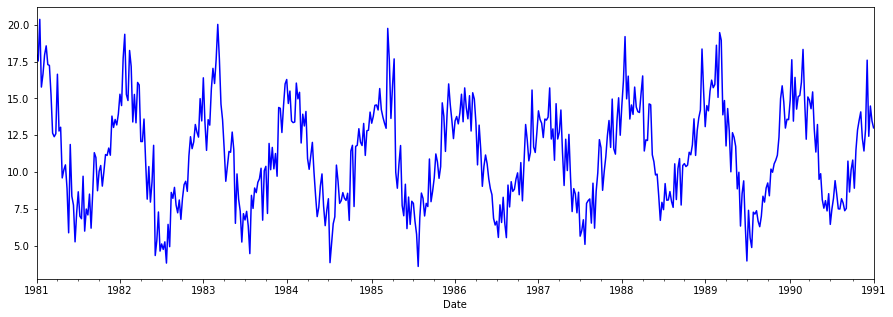

In [9]:
df.Temp.plot(figsize=(15, 5), color="b")

# Dataset Splitting

In [10]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((418, 1), (105, 1))

# Dataset & Dataloader

In [11]:
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [52]:
seq_len = 16
bs = 8

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (26, 16, 1)
Note: last 1 data excluded

(N, S, F): (6, 16, 1)
Note: last 8 data excluded



# Arsitektur & Config

In [53]:
from jcopdl.layers import linear_block

In [54]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [55]:
config = set_config({
    "input_size": train_set.n_feature,
    "output_size": 1, 
    "hidden_size": 64, 
    "num_layers": 2, 
    "dropout": 0,
    "seq_len": train_set.n_seq
})

# Training Preparation -> MCOC

In [56]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/rnn")

# Training

In [57]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 131.2053 | Test_cost  = 120.6653 | 




Epoch     2
Train_cost  = 109.7448 | Test_cost  = 102.2372 | 




Epoch     3
Train_cost  = 92.9515 | Test_cost  = 87.9915 | 




Epoch     4
Train_cost  = 80.0501 | Test_cost  = 77.1602 | 




Epoch     5
Train_cost  = 70.2306 | Test_cost  = 68.8973 | 




Epoch     6
Train_cost  = 62.7374 | Test_cost  = 62.5710 | 




Epoch     7
Train_cost  = 56.9721 | Test_cost  = 57.5616 | 




Epoch     8
Train_cost  = 52.3407 | Test_cost  = 53.3473 | 




Epoch     9
Train_cost  = 48.3906 | Test_cost  = 49.6222 | 




Epoch    10
Train_cost  = 44.8756 | Test_cost  = 46.2495 | 




Epoch    11
Train_cost  = 41.6887 | Test_cost  = 43.1698 | 




Epoch    12
Train_cost  = 38.7801 | Test_cost  = 40.3469 | 




Epoch    13
Train_cost  = 36.1166 | Test_cost  = 37.7536 | 




Epoch    14
Train_cost  = 33.6734 | Test_cost  = 35.3701 | 




Epoch    15
Train_cost  = 31.4327 | Test_cost  = 33.1817 | 




Epoch    16
Train_cost  = 29.3803 | Test_cost  = 31.1757 | 




Epoch    17
Train_cost  = 27.5040 | Test_cost  = 29.3405 | 




Epoch    18
Train_cost  = 25.7924 | Test_cost  = 27.6650 | 




Epoch    19
Train_cost  = 24.2344 | Test_cost  = 26.1387 | 




Epoch    20
Train_cost  = 22.8196 | Test_cost  = 24.7510 | 


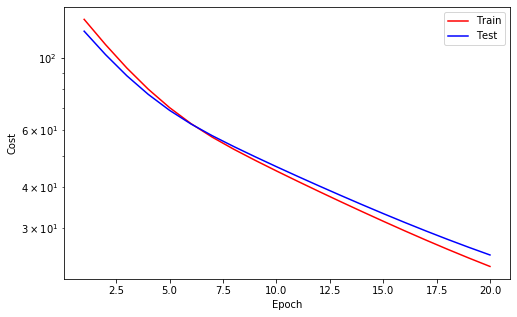



Epoch    21
Train_cost  = 21.5378 | Test_cost  = 23.4922 | 




Epoch    22
Train_cost  = 20.3791 | Test_cost  = 22.3525 | 




Epoch    23
Train_cost  = 19.3341 | Test_cost  = 21.3229 | 




Epoch    24
Train_cost  = 18.3938 | Test_cost  = 20.3948 | 




Epoch    25
Train_cost  = 17.5499 | Test_cost  = 19.5598 | 




Epoch    26
Train_cost  = 16.7941 | Test_cost  = 18.8102 | 




Epoch    27
Train_cost  = 16.1190 | Test_cost  = 18.1387 | 




Epoch    28
Train_cost  = 15.5175 | Test_cost  = 17.5384 | 




Epoch    29
Train_cost  = 14.9828 | Test_cost  = 17.0030 | 




Epoch    30
Train_cost  = 14.5087 | Test_cost  = 16.5263 | 




Epoch    31
Train_cost  = 14.0893 | Test_cost  = 16.1028 | 




Epoch    32
Train_cost  = 13.7194 | Test_cost  = 15.7274 | 




Epoch    33
Train_cost  = 13.3939 | Test_cost  = 15.3952 | 




Epoch    34
Train_cost  = 13.1081 | Test_cost  = 15.1018 | 




Epoch    35
Train_cost  = 12.8578 | Test_cost  = 14.8431 | 




Epoch    36
Train_cost  = 12.6391 | Test_cost  = 14.6154 | 




Epoch    37
Train_cost  = 12.4485 | Test_cost  = 14.4153 | 




Epoch    38
Train_cost  = 12.2828 | Test_cost  = 14.2398 | 




Epoch    39
Train_cost  = 12.1390 | Test_cost  = 14.0860 | 




Epoch    40
Train_cost  = 12.0144 | Test_cost  = 13.9514 | 


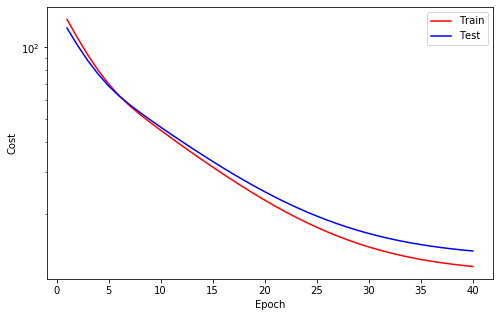



Epoch    41
Train_cost  = 11.9068 | Test_cost  = 13.8337 | 




Epoch    42
Train_cost  = 11.8139 | Test_cost  = 13.7310 | 




Epoch    43
Train_cost  = 11.7340 | Test_cost  = 13.6413 | 




Epoch    44
Train_cost  = 11.6653 | Test_cost  = 13.5631 | 




Epoch    45
Train_cost  = 11.6062 | Test_cost  = 13.4950 | 




Epoch    46
Train_cost  = 11.5556 | Test_cost  = 13.4356 | 




Epoch    47
Train_cost  = 11.5123 | Test_cost  = 13.3839 | 




Epoch    48
Train_cost  = 11.4752 | Test_cost  = 13.3388 | 




Epoch    49
Train_cost  = 11.4434 | Test_cost  = 13.2995 | 




Epoch    50
Train_cost  = 11.4163 | Test_cost  = 13.2653 | 




Epoch    51
Train_cost  = 11.3930 | Test_cost  = 13.2354 | 




Epoch    52
Train_cost  = 11.3732 | Test_cost  = 13.2094 | 




Epoch    53
Train_cost  = 11.3562 | Test_cost  = 13.1866 | 




Epoch    54
Train_cost  = 11.3416 | Test_cost  = 13.1667 | 




Epoch    55
Train_cost  = 11.3291 | Test_cost  = 13.1493 | 




Epoch    56
Train_cost  = 11.3184 | Test_cost  = 13.1340 | 




Epoch    57
Train_cost  = 11.3092 | Test_cost  = 13.1206 | 




Epoch    58
Train_cost  = 11.3012 | Test_cost  = 13.1089 | 




Epoch    59
Train_cost  = 11.2943 | Test_cost  = 13.0985 | 




Epoch    60
Train_cost  = 11.2883 | Test_cost  = 13.0894 | 


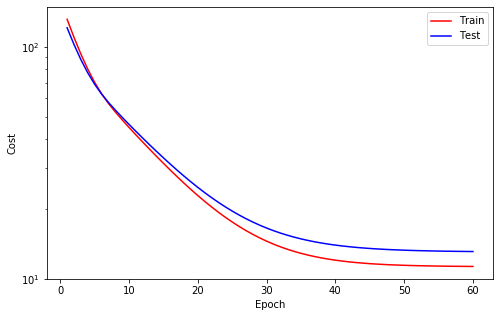



Epoch    61
Train_cost  = 11.2831 | Test_cost  = 13.0813 | 




Epoch    62
Train_cost  = 11.2785 | Test_cost  = 13.0742 | 




Epoch    63
Train_cost  = 11.2745 | Test_cost  = 13.0679 | 




Epoch    64
Train_cost  = 11.2709 | Test_cost  = 13.0622 | 




Epoch    65
Train_cost  = 11.2677 | Test_cost  = 13.0572 | 




Epoch    66
Train_cost  = 11.2649 | Test_cost  = 13.0527 | 




Epoch    67
Train_cost  = 11.2624 | Test_cost  = 13.0487 | 




Epoch    68
Train_cost  = 11.2600 | Test_cost  = 13.0450 | 




Epoch    69
Train_cost  = 11.2579 | Test_cost  = 13.0417 | 




Epoch    70
Train_cost  = 11.2560 | Test_cost  = 13.0387 | 




Epoch    71
Train_cost  = 11.2541 | Test_cost  = 13.0359 | 




Epoch    72
Train_cost  = 11.2524 | Test_cost  = 13.0334 | 




Epoch    73
Train_cost  = 11.2508 | Test_cost  = 13.0310 | 




Epoch    74
Train_cost  = 11.2492 | Test_cost  = 13.0288 | 




Epoch    75
Train_cost  = 11.2477 | Test_cost  = 13.0267 | 




Epoch    76
Train_cost  = 11.2462 | Test_cost  = 13.0247 | 




Epoch    77
Train_cost  = 11.2448 | Test_cost  = 13.0227 | 




Epoch    78
Train_cost  = 11.2433 | Test_cost  = 13.0208 | 




Epoch    79
Train_cost  = 11.2418 | Test_cost  = 13.0190 | 




Epoch    80
Train_cost  = 11.2404 | Test_cost  = 13.0171 | 


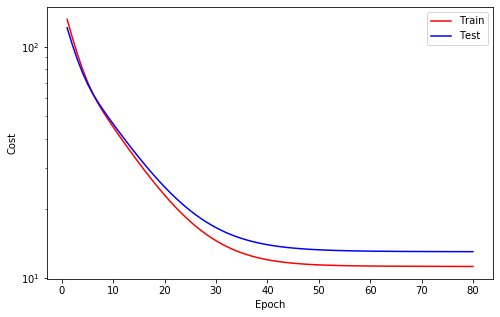



Epoch    81
Train_cost  = 11.2388 | Test_cost  = 13.0152 | 




Epoch    82
Train_cost  = 11.2373 | Test_cost  = 13.0134 | 




Epoch    83
Train_cost  = 11.2357 | Test_cost  = 13.0114 | 




Epoch    84
Train_cost  = 11.2340 | Test_cost  = 13.0094 | 




Epoch    85
Train_cost  = 11.2323 | Test_cost  = 13.0074 | 




Epoch    86
Train_cost  = 11.2304 | Test_cost  = 13.0052 | 




Epoch    87
Train_cost  = 11.2284 | Test_cost  = 13.0029 | 




Epoch    88
Train_cost  = 11.2263 | Test_cost  = 13.0004 | 




Epoch    89
Train_cost  = 11.2240 | Test_cost  = 12.9977 | 




Epoch    90
Train_cost  = 11.2216 | Test_cost  = 12.9948 | 




Epoch    91
Train_cost  = 11.2189 | Test_cost  = 12.9918 | 




Epoch    92
Train_cost  = 11.2160 | Test_cost  = 12.9884 | 




Epoch    93
Train_cost  = 11.2129 | Test_cost  = 12.9847 | 




Epoch    94
Train_cost  = 11.2094 | Test_cost  = 12.9805 | 




Epoch    95
Train_cost  = 11.2055 | Test_cost  = 12.9758 | 




Epoch    96
Train_cost  = 11.2009 | Test_cost  = 12.9702 | 




Epoch    97
Train_cost  = 11.1956 | Test_cost  = 12.9635 | 




Epoch    98
Train_cost  = 11.1891 | Test_cost  = 12.9552 | 




Epoch    99
Train_cost  = 11.1809 | Test_cost  = 12.9445 | 




Epoch   100
Train_cost  = 11.1703 | Test_cost  = 12.9301 | 


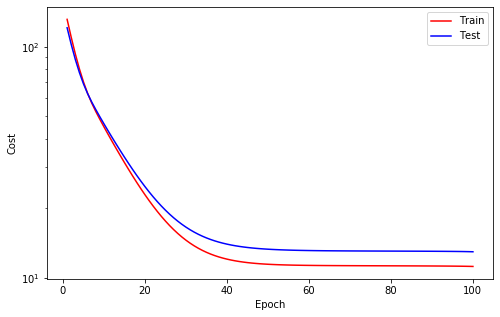



Epoch   101
Train_cost  = 11.1558 | Test_cost  = 12.9094 | 




Epoch   102
Train_cost  = 11.1344 | Test_cost  = 12.8766 | 




Epoch   103
Train_cost  = 11.0992 | Test_cost  = 12.8180 | 




Epoch   104
Train_cost  = 11.0350 | Test_cost  = 12.7155 | 




Epoch   105
Train_cost  = 10.9347 | Test_cost  = 12.6153 | 




Epoch   106
Train_cost  = 10.8367 | Test_cost  = 12.4659 | 




Epoch   107
Train_cost  = 10.6593 | Test_cost  = 12.0829 | 




Epoch   108
Train_cost  = 10.2777 | Test_cost  = 11.3997 | 




Epoch   109
Train_cost  = 9.6759 | Test_cost  = 10.3802 | 




Epoch   110
Train_cost  = 8.8415 | Test_cost  = 9.5429 | 




Epoch   111
Train_cost  = 8.3089 | Test_cost  = 9.3573 | 




Epoch   112
Train_cost  = 8.2211 | Test_cost  = 9.0106 | 




Epoch   113
Train_cost  = 7.8693 | Test_cost  = 8.5660 | 




Epoch   114
Train_cost  = 7.5036 | Test_cost  = 8.2917 | 




Epoch   115
Train_cost  = 7.3047 | Test_cost  = 7.9950 | 




Epoch   116
Train_cost  = 7.0566 | Test_cost  = 7.7282 | 




Epoch   117
Train_cost  = 6.8664 | Test_cost  = 7.4865 | 




Epoch   118
Train_cost  = 6.6728 | Test_cost  = 7.2702 | 




Epoch   119
Train_cost  = 6.5294 | Test_cost  = 7.0736 | 




Epoch   120
Train_cost  = 6.3778 | Test_cost  = 6.8882 | 


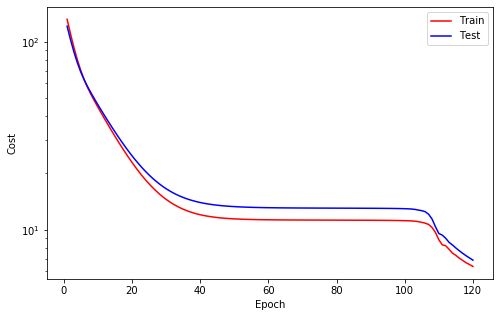



Epoch   121
Train_cost  = 6.2619 | Test_cost  = 6.7225 | 




Epoch   122
Train_cost  = 6.1368 | Test_cost  = 6.5689 | 




Epoch   123
Train_cost  = 6.0360 | Test_cost  = 6.4264 | 




Epoch   124
Train_cost  = 5.9256 | Test_cost  = 6.2945 | 




Epoch   125
Train_cost  = 5.8354 | Test_cost  = 6.1729 | 




Epoch   126
Train_cost  = 5.7400 | Test_cost  = 6.0586 | 




Epoch   127
Train_cost  = 5.6587 | Test_cost  = 5.9510 | 




Epoch   128
Train_cost  = 5.5729 | Test_cost  = 5.8480 | 




Epoch   129
Train_cost  = 5.4956 | Test_cost  = 5.7486 | 




Epoch   130
Train_cost  = 5.4135 | Test_cost  = 5.6513 | 




Epoch   131
Train_cost  = 5.3349 | Test_cost  = 5.5552 | 




Epoch   132
Train_cost  = 5.2510 | Test_cost  = 5.4595 | 




Epoch   133
Train_cost  = 5.1673 | Test_cost  = 5.3645 | 




Epoch   134
Train_cost  = 5.0795 | Test_cost  = 5.2707 | 




Epoch   135
Train_cost  = 4.9935 | Test_cost  = 5.1779 | 




Epoch   136
Train_cost  = 4.9083 | Test_cost  = 5.0858 | 




Epoch   137
Train_cost  = 4.8275 | Test_cost  = 4.9953 | 




Epoch   138
Train_cost  = 4.7504 | Test_cost  = 4.9076 | 




Epoch   139
Train_cost  = 4.6780 | Test_cost  = 4.8233 | 




Epoch   140
Train_cost  = 4.6101 | Test_cost  = 4.7425 | 


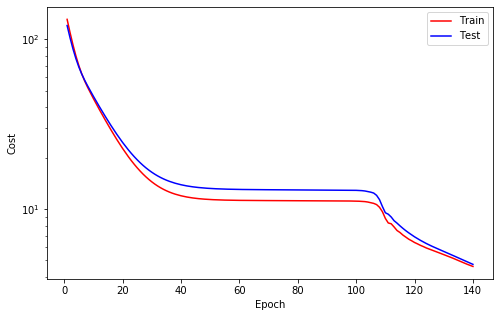



Epoch   141
Train_cost  = 4.5449 | Test_cost  = 4.6644 | 




Epoch   142
Train_cost  = 4.4837 | Test_cost  = 4.5890 | 




Epoch   143
Train_cost  = 4.4238 | Test_cost  = 4.5151 | 




Epoch   144
Train_cost  = 4.3672 | Test_cost  = 4.4430 | 




Epoch   145
Train_cost  = 4.3116 | Test_cost  = 4.3721 | 




Epoch   146
Train_cost  = 4.2592 | Test_cost  = 4.3030 | 




Epoch   147
Train_cost  = 4.2081 | Test_cost  = 4.2358 | 




Epoch   148
Train_cost  = 4.1596 | Test_cost  = 4.1710 | 




Epoch   149
Train_cost  = 4.1128 | Test_cost  = 4.1090 | 




Epoch   150
Train_cost  = 4.0682 | Test_cost  = 4.0500 | 




Epoch   151
Train_cost  = 4.0257 | Test_cost  = 3.9941 | 




Epoch   152
Train_cost  = 3.9850 | Test_cost  = 3.9412 | 




Epoch   153
Train_cost  = 3.9464 | Test_cost  = 3.8913 | 




Epoch   154
Train_cost  = 3.9095 | Test_cost  = 3.8442 | 




Epoch   155
Train_cost  = 3.8746 | Test_cost  = 3.7997 | 




Epoch   156
Train_cost  = 3.8414 | Test_cost  = 3.7578 | 




Epoch   157
Train_cost  = 3.8099 | Test_cost  = 3.7184 | 




Epoch   158
Train_cost  = 3.7801 | Test_cost  = 3.6814 | 




Epoch   159
Train_cost  = 3.7519 | Test_cost  = 3.6469 | 




Epoch   160
Train_cost  = 3.7254 | Test_cost  = 3.6146 | 


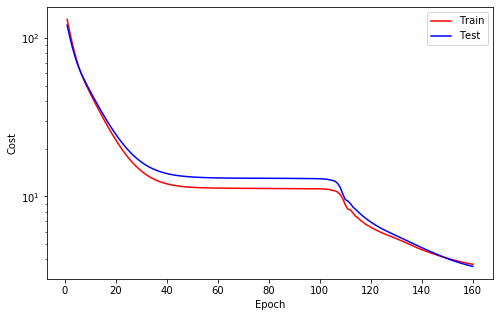



Epoch   161
Train_cost  = 3.7003 | Test_cost  = 3.5844 | 




Epoch   162
Train_cost  = 3.6767 | Test_cost  = 3.5563 | 




Epoch   163
Train_cost  = 3.6544 | Test_cost  = 3.5299 | 




Epoch   164
Train_cost  = 3.6333 | Test_cost  = 3.5052 | 




Epoch   165
Train_cost  = 3.6133 | Test_cost  = 3.4820 | 




Epoch   166
Train_cost  = 3.5943 | Test_cost  = 3.4599 | 




Epoch   167
Train_cost  = 3.5763 | Test_cost  = 3.4386 | 




Epoch   168
Train_cost  = 3.5592 | Test_cost  = 3.4178 | 




Epoch   169
Train_cost  = 3.5429 | Test_cost  = 3.3976 | 




Epoch   170
Train_cost  = 3.5274 | Test_cost  = 3.3780 | 




Epoch   171
Train_cost  = 3.5125 | Test_cost  = 3.3591 | 




Epoch   172
Train_cost  = 3.4982 | Test_cost  = 3.3409 | 




Epoch   173
Train_cost  = 3.4846 | Test_cost  = 3.3235 | 




Epoch   174
Train_cost  = 3.4716 | Test_cost  = 3.3067 | 




Epoch   175
Train_cost  = 3.4592 | Test_cost  = 3.2904 | 




Epoch   176
Train_cost  = 3.4474 | Test_cost  = 3.2744 | 




Epoch   177
Train_cost  = 3.4360 | Test_cost  = 3.2587 | 




Epoch   178
Train_cost  = 3.4251 | Test_cost  = 3.2433 | 




Epoch   179
Train_cost  = 3.4147 | Test_cost  = 3.2284 | 




Epoch   180
Train_cost  = 3.4046 | Test_cost  = 3.2139 | 


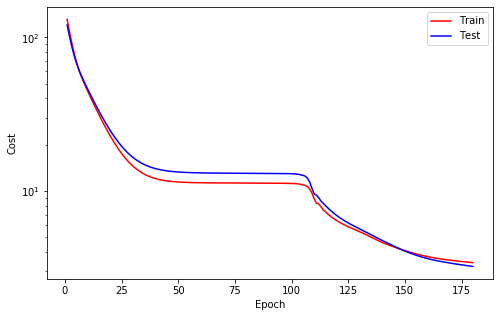



Epoch   181
Train_cost  = 3.3950 | Test_cost  = 3.1998 | 




Epoch   182
Train_cost  = 3.3856 | Test_cost  = 3.1861 | 




Epoch   183
Train_cost  = 3.3765 | Test_cost  = 3.1728 | 




Epoch   184
Train_cost  = 3.3676 | Test_cost  = 3.1597 | 




Epoch   185
Train_cost  = 3.3588 | Test_cost  = 3.1471 | 




Epoch   186
Train_cost  = 3.3501 | Test_cost  = 3.1347 | 




Epoch   187
Train_cost  = 3.3414 | Test_cost  = 3.1227 | 




Epoch   188
Train_cost  = 3.3329 | Test_cost  = 3.1109 | 




Epoch   189
Train_cost  = 3.3244 | Test_cost  = 3.0995 | 




Epoch   190
Train_cost  = 3.3159 | Test_cost  = 3.0884 | 




Epoch   191
Train_cost  = 3.3074 | Test_cost  = 3.0775 | 




Epoch   192
Train_cost  = 3.2989 | Test_cost  = 3.0669 | 




Epoch   193
Train_cost  = 3.2905 | Test_cost  = 3.0565 | 




Epoch   194
Train_cost  = 3.2820 | Test_cost  = 3.0461 | 




Epoch   195
Train_cost  = 3.2735 | Test_cost  = 3.0358 | 




Epoch   196
Train_cost  = 3.2650 | Test_cost  = 3.0255 | 




Epoch   197
Train_cost  = 3.2566 | Test_cost  = 3.0153 | 




Epoch   198
Train_cost  = 3.2483 | Test_cost  = 3.0051 | 




Epoch   199
Train_cost  = 3.2402 | Test_cost  = 2.9953 | 




Epoch   200
Train_cost  = 3.2325 | Test_cost  = 2.9860 | 


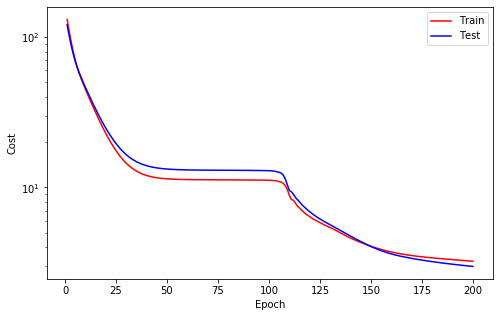



Epoch   201
Train_cost  = 3.2253 | Test_cost  = 2.9769 | 




Epoch   202
Train_cost  = 3.2185 | Test_cost  = 2.9676 | 




Epoch   203
Train_cost  = 3.2120 | Test_cost  = 2.9579 | 




Epoch   204
Train_cost  = 3.2055 | Test_cost  = 2.9473 | 




Epoch   205
Train_cost  = 3.1989 | Test_cost  = 2.9362 | 




Epoch   206
Train_cost  = 3.1920 | Test_cost  = 2.9252 | 




Epoch   207
Train_cost  = 3.1849 | Test_cost  = 2.9146 | 




Epoch   208
Train_cost  = 3.1778 | Test_cost  = 2.9044 | 




Epoch   209
Train_cost  = 3.1708 | Test_cost  = 2.8948 | 




Epoch   210
Train_cost  = 3.1640 | Test_cost  = 2.8861 | 




Epoch   211
Train_cost  = 3.1575 | Test_cost  = 2.8780 | 




Epoch   212
Train_cost  = 3.1513 | Test_cost  = 2.8704 | 




Epoch   213
Train_cost  = 3.1452 | Test_cost  = 2.8634 | 




Epoch   214
Train_cost  = 3.1395 | Test_cost  = 2.8568 | 




Epoch   215
Train_cost  = 3.1339 | Test_cost  = 2.8504 | 




Epoch   216
Train_cost  = 3.1285 | Test_cost  = 2.8445 | 




Epoch   217
Train_cost  = 3.1232 | Test_cost  = 2.8389 | 




Epoch   218
Train_cost  = 3.1180 | Test_cost  = 2.8337 | 




Epoch   219
Train_cost  = 3.1128 | Test_cost  = 2.8289 | 




Epoch   220
Train_cost  = 3.1077 | Test_cost  = 2.8246 | 


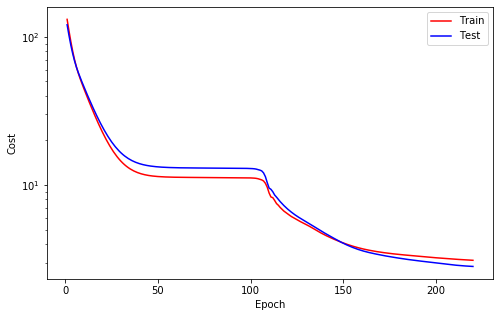



Epoch   221
Train_cost  = 3.1027 | Test_cost  = 2.8206 | 




Epoch   222
Train_cost  = 3.0977 | Test_cost  = 2.8172 | 




Epoch   223
Train_cost  = 3.0927 | Test_cost  = 2.8141 | 




Epoch   224
Train_cost  = 3.0878 | Test_cost  = 2.8115 | 




Epoch   225
Train_cost  = 3.0829 | Test_cost  = 2.8093 | 




Epoch   226
Train_cost  = 3.0781 | Test_cost  = 2.8074 | 




Epoch   227
Train_cost  = 3.0733 | Test_cost  = 2.8058 | 




Epoch   228
Train_cost  = 3.0685 | Test_cost  = 2.8046 | 




Epoch   229
Train_cost  = 3.0638 | Test_cost  = 2.8036 | 




Epoch   230
Train_cost  = 3.0590 | Test_cost  = 2.8029 | 




Epoch   231
Train_cost  = 3.0543 | Test_cost  = 2.8025 | 




Epoch   232
Train_cost  = 3.0496 | Test_cost  = 2.8023 | 




Epoch   233
Train_cost  = 3.0450 | Test_cost  = 2.8023 | 
==> EarlyStop patience =  1 | Best test_cost: 2.8023




Epoch   234
Train_cost  = 3.0403 | Test_cost  = 2.8025 | 
==> EarlyStop patience =  2 | Best test_cost: 2.8023




Epoch   235
Train_cost  = 3.0357 | Test_cost  = 2.8028 | 
==> EarlyStop patience =  3 | Best test_cost: 2.8023




Epoch   236
Train_cost  = 3.0312 | Test_cost  = 2.8032 | 
==> EarlyStop patience =  4 | Best test_cost: 2.8023




Epoch   237
Train_cost  = 3.0266 | Test_cost  = 2.8038 | 
==> EarlyStop patience =  5 | Best test_cost: 2.8023
==> Execute Early Stopping at epoch: 237 | Best test_cost: 2.8023
==> Best model is saved at model/rnn


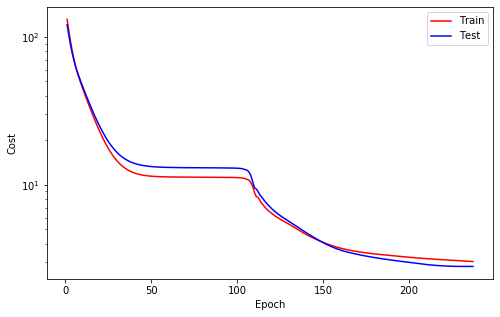

In [58]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Forecast

In [59]:
from luwiji.rnn import illustration

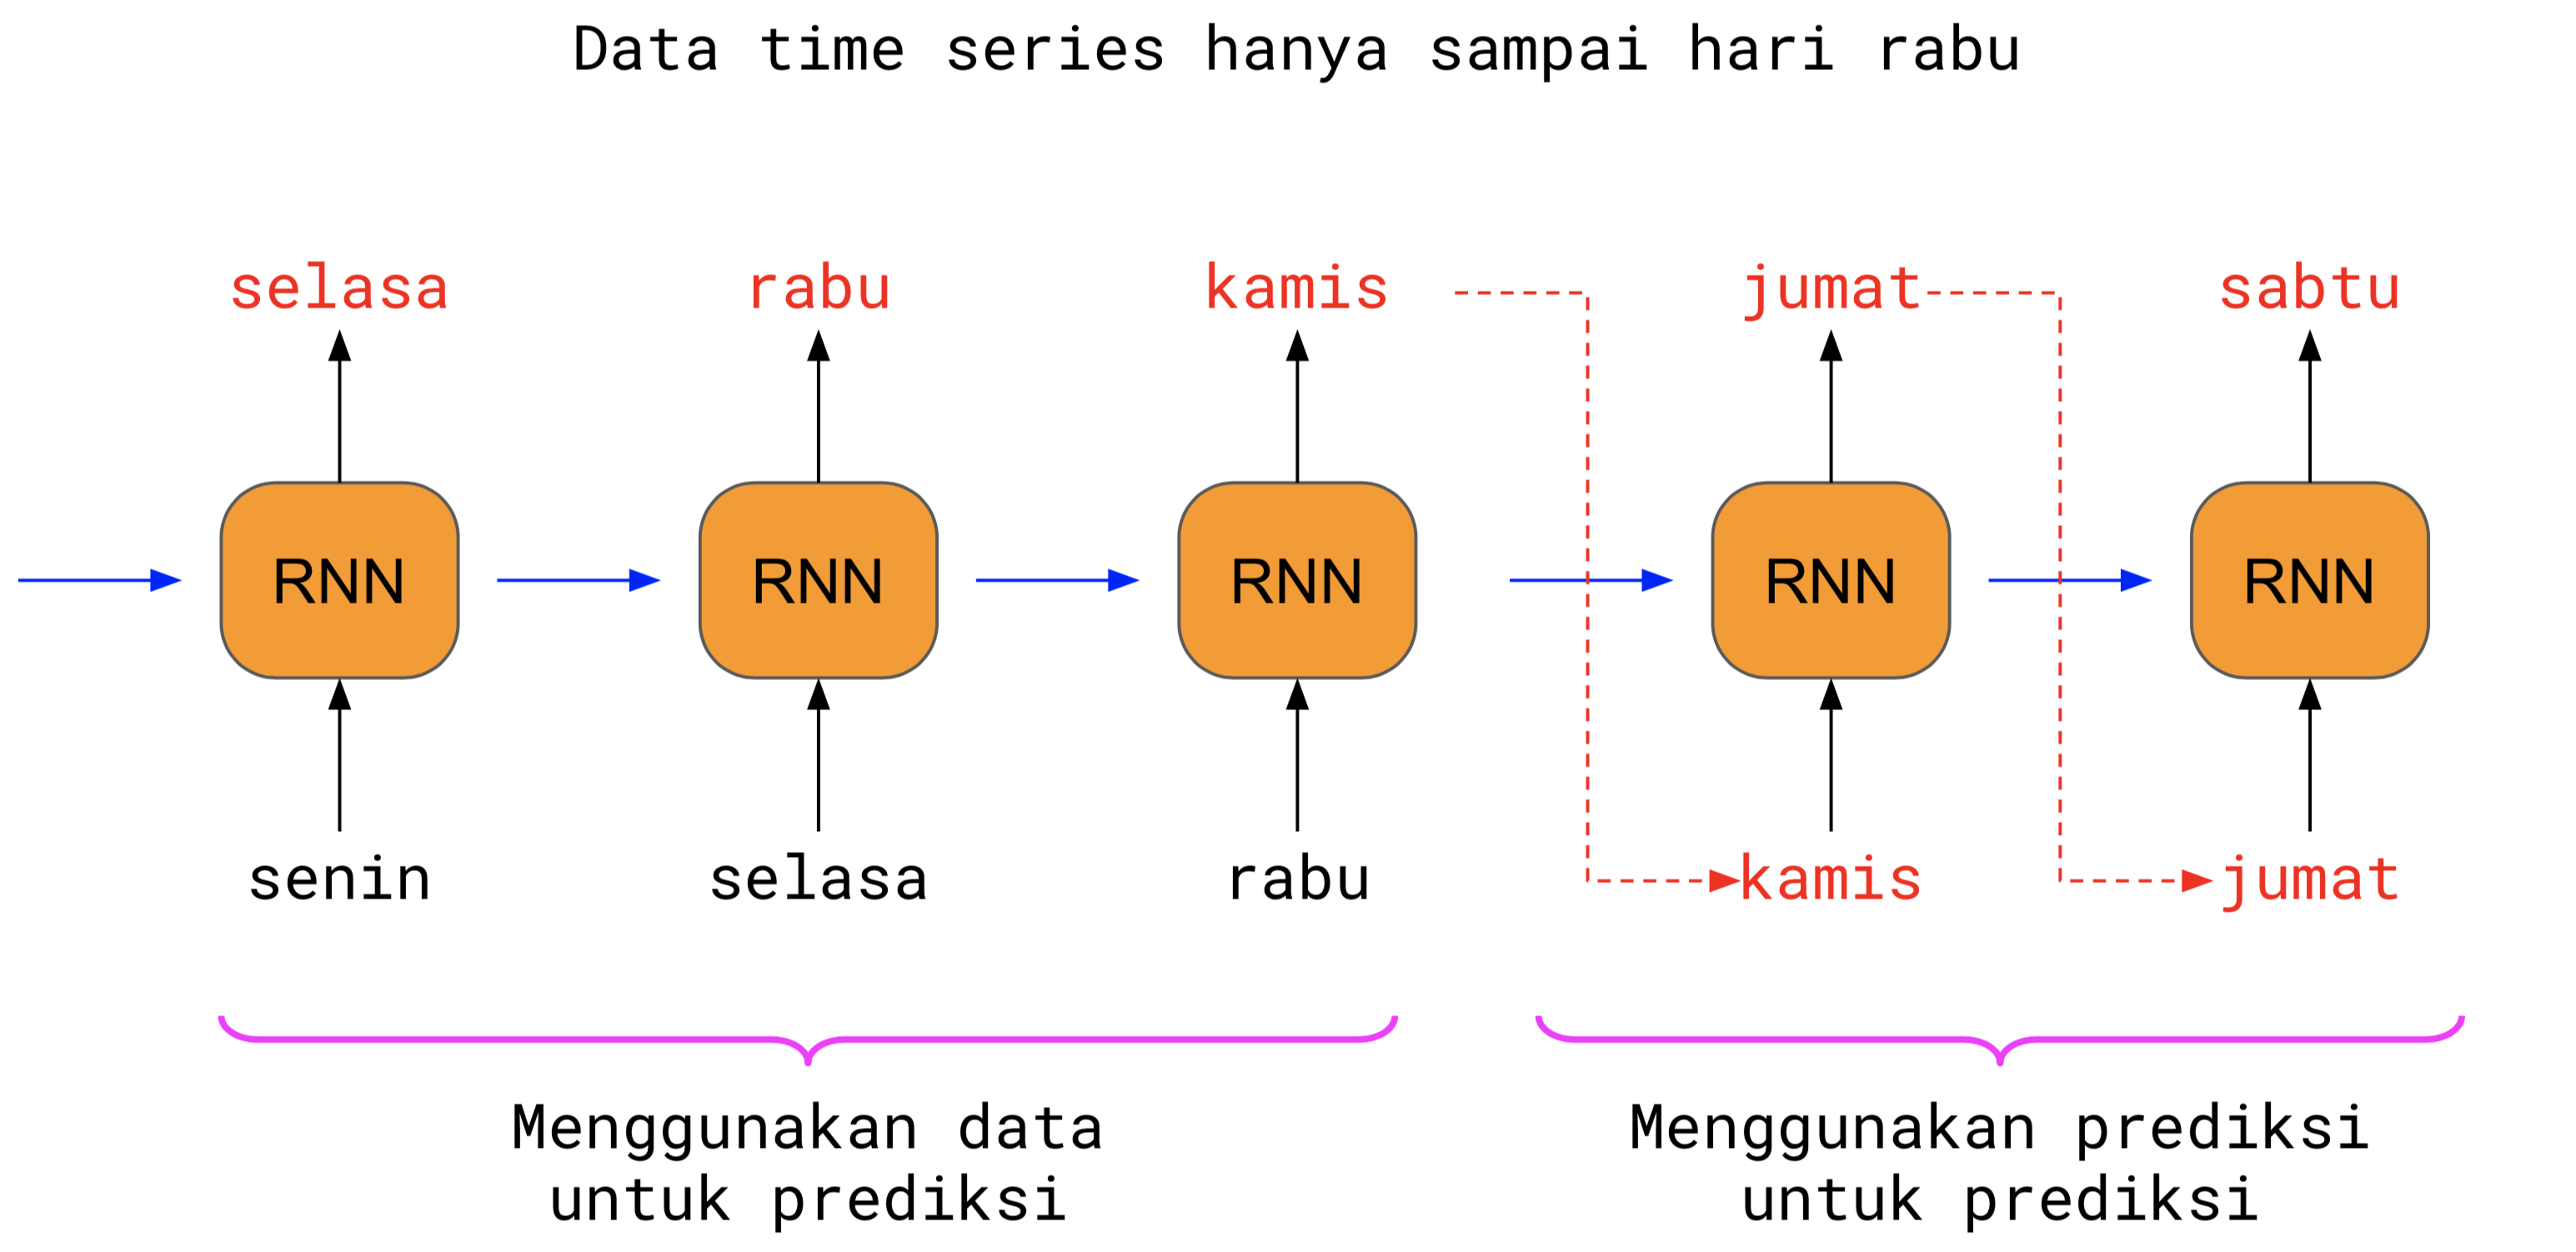

In [60]:
illustration.forecast

In [61]:
from utils import data4pred, pred4pred

In [65]:
import torch
import matplotlib.pyplot as plt
    
def data4pred(model, dataset, dataloader, device):    
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)
            
            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks, targets, 'b-', label="data")
    plt.plot(dataset.target_ticks, preds, 'r-', label="pred")
    plt.legend()    
    
def pred4pred(model, dataset, dataloader, device, n_prior=80, n_forecast=50):
    preds, targets = [], []
    hidden = None    
    end = n_prior + n_forecast    
    with torch.no_grad():
        model.eval()       
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]
                
            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)
            
            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()   
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle="--", linewidth=1)
    plt.legend()            

In [62]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (417, 1, 1)
Note: last 0 data excluded

(N, S, F): (104, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

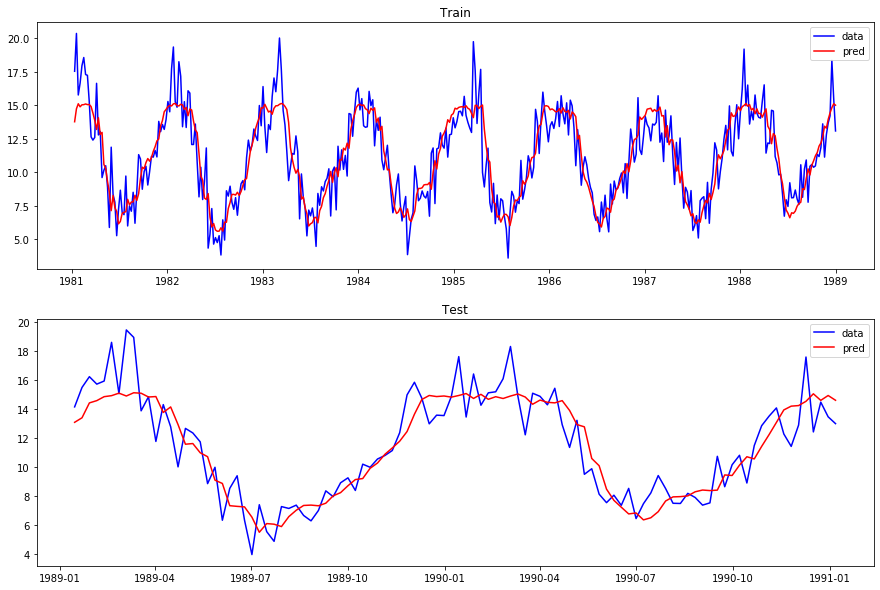

In [63]:
plt.figure(figsize=(15, 10))
    
plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

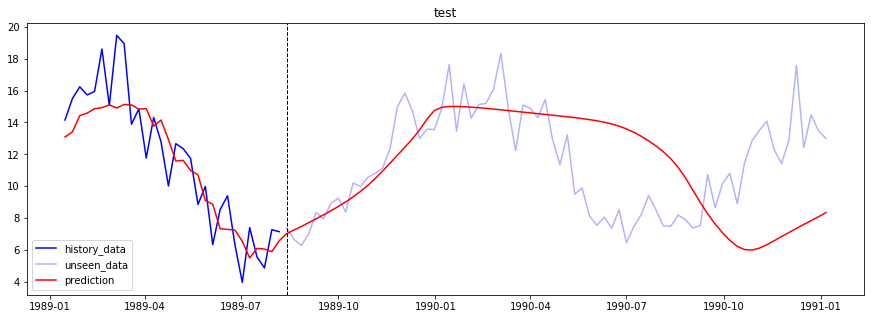

In [68]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device, n_prior=30, n_forecast=110)
plt.title("test");